In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pp
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import parallel_backend
from sklearn.decomposition import PCA

In [2]:
# feature path
path = os.path.join(os.getcwd(), 'data', 't_invar')

In [3]:
# load features
train = pd.read_csv(os.path.join(path, 'train.csv'), header=[0, 1, 2])
dev = pd.read_csv(os.path.join(path, 'dev.csv'), header=[0, 1, 2])
test = pd.read_csv(os.path.join(path, 'test.csv'), header=[0, 1, 2])

In [4]:
train.head()

chroma_cens                                                              \
          max                                                               
            1         2         3         4         5         6         7   
0    0.401753  0.293586  0.279790  0.254710  0.302921  0.247716  0.138682   
1    0.209346  0.261439  0.287935  0.307697  0.296488  0.363665  0.348933   
2    0.239863  0.031924  0.140360  0.063839  0.334769  0.739948  0.148755   
3    0.169833  0.250565  0.292196  0.293550  0.390041  0.299625  0.314494   
4    0.324970  0.110158  0.272007  0.416902  0.180768  0.090371  0.018058   

                                 ...   tonnetz                 zcr            \
                                 ...       std                 max      mean   
          8         9        10  ...         5         6         1         1   
0  0.323174  0.266797  0.230696  ...  0.043161  0.040683  0.055642  0.038845   
1  0.286316  0.255562  0.201479  ...  0.043490  0.051108  0.171417  0.053200   
2  0.255695  0.008915  0.252440  ... -0.002708  0.061586  0.058838  0.009310   
3  0.254559  0.262152  0.236500  ...  0.080263  0.036752  0.158432  0.069996   
4  0.320504  0.130948  0.334092  ...  0.130417  0.213566  0.092649  0.032778   

                                                                  target  
     median       min  kurtosis      skew       std Unnamed: 469_level_1  
          1         1         1         1         1 Unnamed: 469_level_2  
0  0.985879  0.289423  0.051758  0.007812  0.156250                    8  
1  0.560498  0.877931  0.165527  0.051270  0.345703                    4  
2 -0.604153  1.129661  0.059814  0.028320  0.081055                    1  
3  0.253030  0.068039  0.160889  0.019531  0.325195                    3  
4  0.866067 -0.309483  0.083008  0.042969  0.167969                    1  

[5 rows x 470 columns]

In [5]:
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [6]:
X_train = train.iloc[:, :-1].values
y_train = train.iloc[:, -1].values
X_dev = dev.iloc[:, :-1].values
y_dev = dev.iloc[:, -1].values
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values
X_test = np.concatenate((X_test, X_dev), axis=0)
y_test = np.concatenate((y_test, y_dev), axis=0)

In [7]:
print('Train size: {}'.format(X_train.shape))
print('Test size: {}'.format(X_test.shape))

Train size: (8000, 469)
Test size: (2000, 469)


In [8]:
logit = LogisticRegression(max_iter=1000, tol=5e-5, multi_class='multinomial', class_weight='balanced')
pipe = Pipeline(steps=[('scale', StandardScaler()), ('logit', logit)])

## Hyperparameter Optimization

In [9]:
param_grid = {'logit__C': np.logspace(-2, 1, 50)}

In [10]:
search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=0, scoring='f1_macro')
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('logit',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           multi_class='multinomial',
                                                           tol=5e-05))]),
             n_jobs=-1,
             param_grid={'logit__C': array([ 0.01      ,  0.01151395,  0.01325711,  0.01526418,  0.01757511,
        0.0202359 ,  0.02329952,  0.02682696,  0.03088844,  0.0355648 ,
        0.04094915,  0.04714866,  0.05428675,  0.0...
        0.08286428,  0.09540955,  0.10985411,  0.12648552,  0.14563485,
        0.16768329,  0.19306977,  0.22229965,  0.25595479,  0.29470517,
        0.33932218,  0.39069399,  0.44984327,  0.51794747,  0.59636233,
        0.68664885,  0.79060432,  0.91029818,  1.04811313,  1.20679264,
        1.38949549

In [11]:
search.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('logit',
                 LogisticRegression(C=0.07196856730011521,
                                    class_weight='balanced', max_iter=1000,
                                    multi_class='multinomial', tol=5e-05))])

In [16]:
search.score(X_test, y_test)

0.8304985040023778

In [13]:
train_report = pd.DataFrame(classification_report(y_train, search.predict(X_train), target_names=class_names, output_dict=True)).transpose().drop('support', axis=1)
test_report = pd.DataFrame(classification_report(y_test, search.predict(X_test), target_names=class_names, output_dict=True)).transpose().drop('support', axis=1)
report = pd.concat((train_report, test_report), axis=1)
report.columns = pd.MultiIndex.from_product([['Training Data', 'Test Data'], train_report.columns])
color_map = sns.light_palette("green", as_cmap=True)
report.style.background_gradient(cmap=color_map, low=0, high=1)

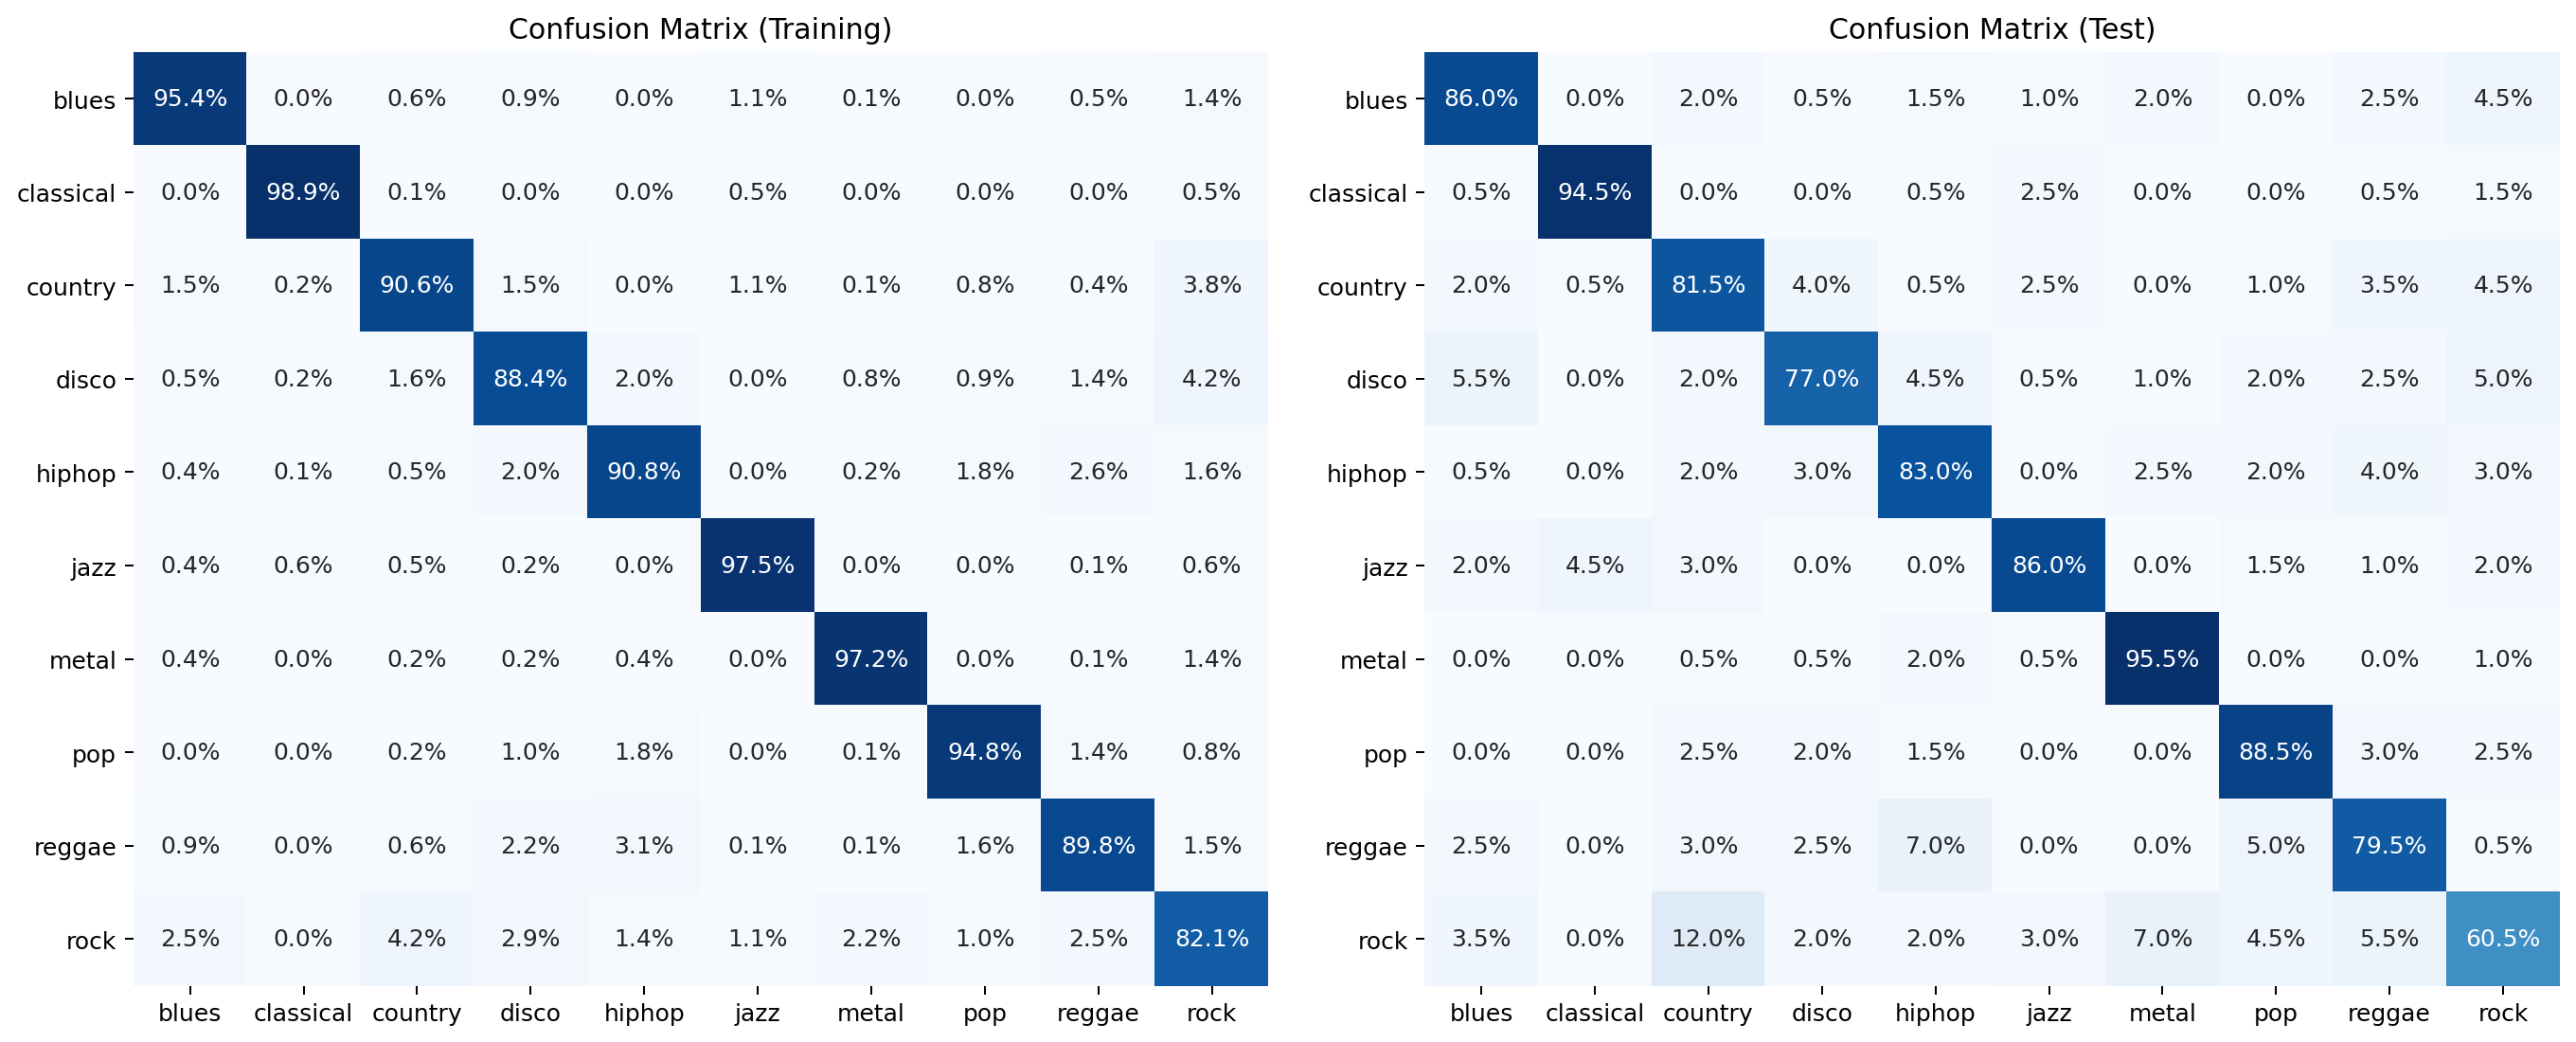

In [14]:
fig, axs = pp.subplots(1, 2, figsize=(15, 6), dpi=180, constrained_layout=True)
pp.rcParams.update({'font.size': 10})
cm = confusion_matrix(y_train, search.predict(X_train))
sns.heatmap(cm/(X_train.shape[0]/10) * 100, annot=True, fmt = '.1f', ax=axs[0], xticklabels=class_names, yticklabels=class_names, cmap='Blues', cbar=False)
cm = confusion_matrix(y_test, search.predict(X_test))
sns.heatmap(cm/(X_test.shape[0]/10) * 100, annot=True, fmt = '.1f', ax=axs[1], xticklabels=class_names, yticklabels=class_names, cmap='Blues', cbar=False)
for t in axs[0].texts: t.set_text(t.get_text() + "%")
for t in axs[1].texts: t.set_text(t.get_text() + "%")
axs[0].set_title('Confusion Matrix (Training)')
axs[1].set_title('Confusion Matrix (Test)')
axs[0].set_yticklabels(class_names, rotation=0)
axs[1].set_yticklabels(class_names, rotation=0);

In [15]:
for idx, cl in enumerate(class_names):
    col_indx = np.abs(search.best_estimator_[1].coef_[idx, :]).argsort()[::-1][:10]
    print('Class Name: ' + cl.title())
    print(train.iloc[:, col_indx].columns)

Class Name: Blues
MultiIndex([('spectral_contrast',      'std', '7'),
            (             'rmse',     'mean', '1'),
            (             'mfcc',      'max', '3'),
            (             'mfcc', 'kurtosis', '3'),
            ('spectral_contrast',      'max', '7'),
            ('spectral_contrast',      'min', '7'),
            (             'mfcc',   'median', '3'),
            (             'rmse',      'max', '1'),
            (             'mfcc',     'mean', '5'),
            (      'chroma_stft',     'skew', '9')],
           )
Class Name: Classical
MultiIndex([('mfcc',     'mean', '4'),
            ('mfcc',     'mean', '6'),
            ('mfcc',      'std', '1'),
            ('mfcc',      'max', '1'),
            ('mfcc',      'std', '4'),
            ('mfcc', 'kurtosis', '1'),
            ('mfcc',      'std', '6'),
            ('mfcc',     'skew', '1'),
            ('mfcc',   'median', '1'),
            ( 'zcr',     'skew', '1')],
           )
Class Name: Country
Mu